In [1]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining the dataset**

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

**Finetuning from a pretrained model (Option 1)**

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_fine_tuned_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

Downloading some utility scripts and setting up data augmentation/transformations



In [4]:
# Download utility scripts for object detection from the PyTorch Vision GitHub repository

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#

# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T
import utils

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


 ***Training and validation for our Fine-Tuned Model***



In [5]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_fine_tuned_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 92.1MB/s]


Epoch: [0]  [ 0/60]  eta: 0:12:14  lr: 0.000090  loss: 9.9941 (9.9941)  loss_classifier: 0.9717 (0.9717)  loss_box_reg: 0.2146 (0.2146)  loss_mask: 8.7743 (8.7743)  loss_objectness: 0.0326 (0.0326)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 12.2345  data: 3.3264  max mem: 2151
Epoch: [0]  [10/60]  eta: 0:01:20  lr: 0.000936  loss: 2.5403 (4.3461)  loss_classifier: 0.5083 (0.5573)  loss_box_reg: 0.2605 (0.2714)  loss_mask: 1.6730 (3.4892)  loss_objectness: 0.0193 (0.0230)  loss_rpn_box_reg: 0.0039 (0.0052)  time: 1.6123  data: 0.3083  max mem: 3407
Epoch: [0]  [20/60]  eta: 0:00:43  lr: 0.001783  loss: 1.0655 (2.6353)  loss_classifier: 0.1359 (0.3474)  loss_box_reg: 0.1742 (0.2197)  loss_mask: 0.5585 (2.0381)  loss_objectness: 0.0197 (0.0249)  loss_rpn_box_reg: 0.0038 (0.0051)  time: 0.5348  data: 0.0090  max mem: 3407
Epoch: [0]  [30/60]  eta: 0:00:27  lr: 0.002629  loss: 0.6801 (1.9754)  loss_classifier: 0.0949 (0.2621)  loss_box_reg: 0.1624 (0.2047)  loss_mask: 0.3543 (1.4814)  loss_o

**Comments on training log:**

In the above training log, note the last batch of the 10th epoch result.

Epoch: [9]  [59/60]  eta: 0:00:00  lr: 0.000005  loss: 0.1646 (0.1758)  loss_classifier: 0.0197 (0.0221)  loss_box_reg: 0.0283 (0.0343)  loss_mask: 0.1131 (0.1162)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0018 (0.0024)  time: 0.6305  data: 0.0085  max mem: 3779

Here, the loss value in paranthesis represents the cumulative loss over the entire epoch upto that point( here its the last batch so its for the entire epoch ) using the weights after the completion of the 10th epoch.

Similarly for loss_classifier, loss_mask,oss_objectness, loss_rpn_box_reg

These results can be used for comparing the model performance asked in Q5B)

**Testing of finetuned model on Beatles_Abbey_Road Test image: (Method 1)**

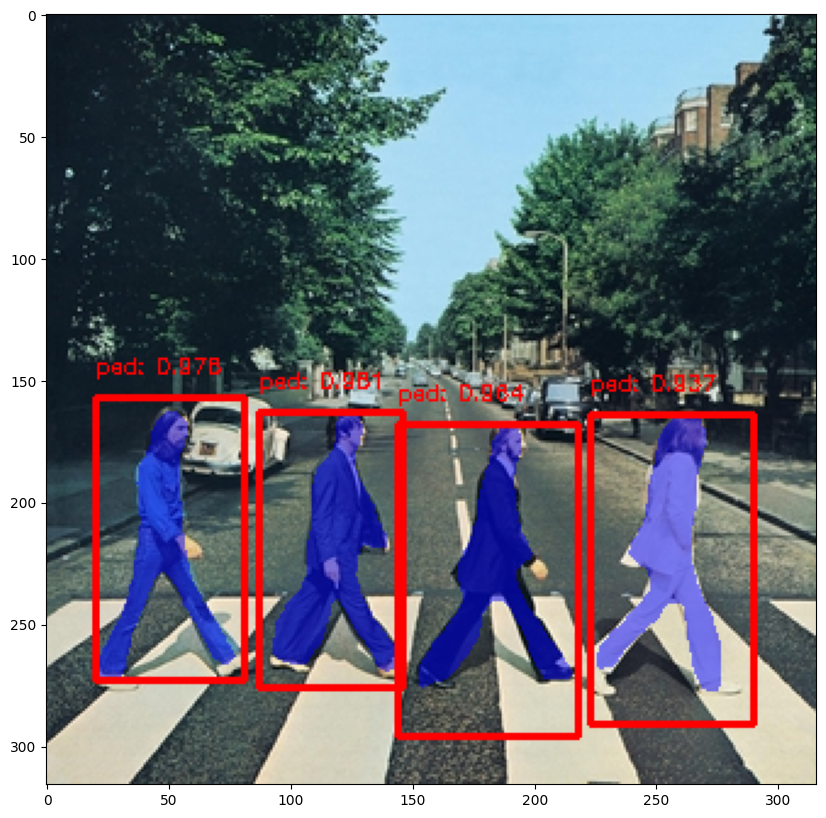

In [22]:
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Read an image from a specified path
image = read_image("/content/sample_data/Beatles_-_Abbey_Road.jpeg")

# Create an output image to visualize the results
output_image = image

# Obtain an evaluation transformation with 'train=False'
eval_transform = get_transform(train=False)

# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    # Make predictions using the model
    predictions = model([x, ])
    pred = predictions[0]

# Normalize and convert the image to 8-bit integers (uint8)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Filter predictions based on confidence scores (only keep scores > 0.65)
# mask refers to binary-mask ie true, false of predictions above confidence( not meaning the mask displayed in the image)
mask = pred["scores"] > 0.65
filtered_pred = {key: value[mask] for key, value in pred.items()}


#Obtaining labels, boxes and masks for filtered predictions
filtered_labels = [f"ped: {score:.3f}" for score in filtered_pred["scores"]]
filtered_boxes = filtered_pred["boxes"].long()
masks = (filtered_pred["masks"] > 0.7).squeeze(1)

#output image having the filtered prediction masks now
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Convert to NumPy array
output_image = output_image.permute(1, 2, 0).cpu().numpy().copy()

#Drawing the boxes, labels using cv2
for label, box in zip(filtered_labels, filtered_boxes):
    x_1, y_1, x_2, y_2 = [coord.item() for coord in box]
    output_image = cv2.rectangle(output_image, (x_1, y_1), (x_2, y_2), (255, 0, 0), 2)
    output_image = cv2.putText(output_image, label, (x_1, y_1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

#Plotting the final image
plt.figure(figsize=(10, 10))
plt.imshow(output_image)



In [25]:
print(pred["scores"])

tensor([0.9806, 0.9776, 0.9639, 0.9368, 0.1338, 0.1002, 0.0907],
       device='cuda:0')


**Comments on testing (method 1) result:**

In the above method for testing, predictions were inferred from the model. Each prediction dictionary consisted of labels, boxes, masks, confidence scores as keys.

Using confidence score threshold of 0.7, predictions in the list were filtered and the corresponding boxes, labels, masks for the the filtered predictions were outputed. In this case, out of all prediction scores (as printed above) four of them crossed the threshold.

**Testing of finetuned model on Beatles_Abbey_Road Test image: (Method 2)**

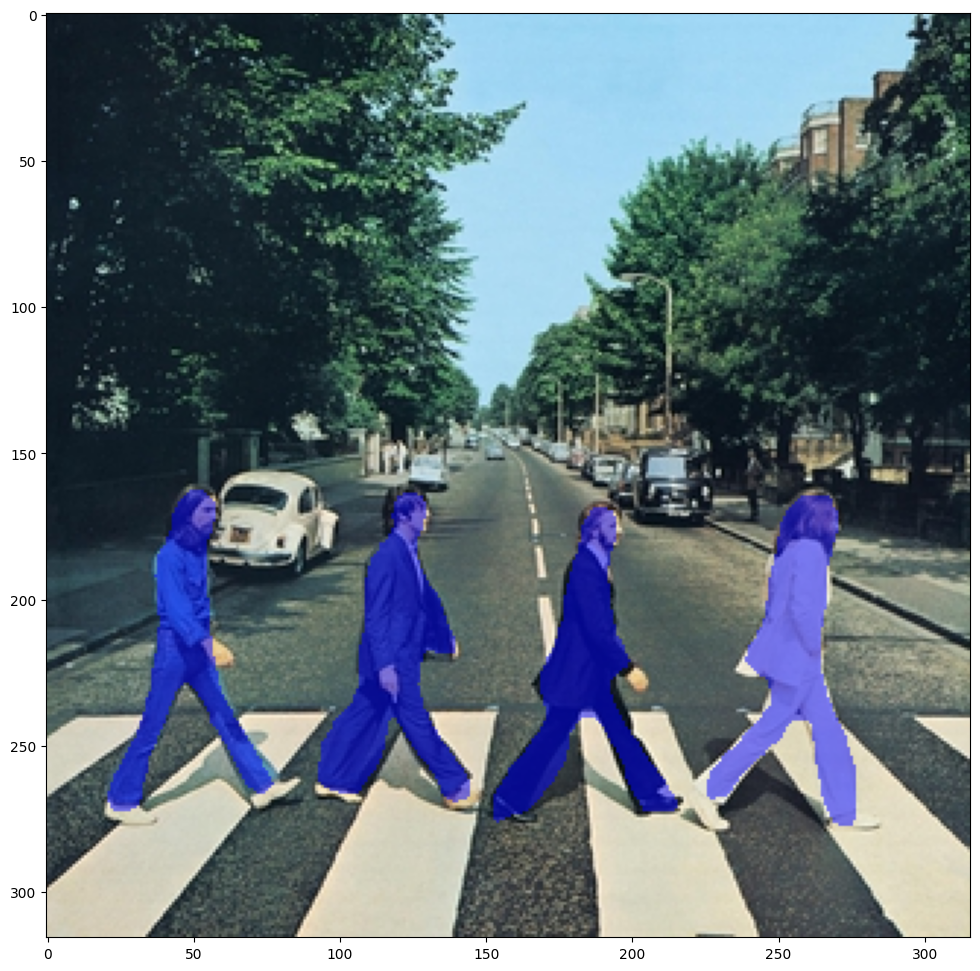

In [26]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Read an image from a specified path
image = read_image("/content/sample_data/Beatles_-_Abbey_Road.jpeg")

# Create an output image to visualize the results
output_image = image

# Obtain an evaluation transformation with 'train=False'
eval_transform = get_transform(train=False)

# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    # Make predictions using the model
    predictions = model([x, ])
    pred = predictions[0]

# Normalize and convert the image to 8-bit integers (uint8)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

#Filtering masks based on confidence
masks = (pred["masks"] > 0.7).squeeze(1)

#output image having the filtered prediction masks now
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

#Plotting the final output image
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))



**Comments on testing (method 2) result:**

In the above method for testing, predictions were inferred from the model.

From each prediction, the corresponding masks whose values exceeded the set threshold were used for the output image.

Prediction dictionaries with low scores like 0.1 etc might have some values in their masks as 0.8 etc ( above the threshod). These masks are included in this method but discared in the previous method.

**2 - Modifying the model to add a different backbone - Mobilenet ( Option 2)**

In [28]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN



def get_backbone_model_instance_segmentation(num_classes):
    # Load a pre-trained model for classification and return only the features
    backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
    # Set the number of output channels in the backbone to 1280
    backbone.out_channels = 1280

    # Define the anchor generator with desired anchor sizes and aspect ratios
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # Define the feature maps to use for region of interest cropping and resizing
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2,
    )

    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                              output_size=14,
                                                              sampling_ratio=2)


    # Create a Mask R-CNN model with the custom backbone
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        mask_roi_pool=mask_roi_pooler
    )



    return model


Q5A) The above is the code for the modified backbone model.

 ***Training and validation for our Modified backbone Model***

In [29]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_backbone_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 27.0MB/s]


Epoch: [0]  [ 0/60]  eta: 0:01:18  lr: 0.000090  loss: 3.8727 (3.8727)  loss_classifier: 0.6975 (0.6975)  loss_box_reg: 0.0829 (0.0829)  loss_mask: 2.2960 (2.2960)  loss_objectness: 0.6972 (0.6972)  loss_rpn_box_reg: 0.0992 (0.0992)  time: 1.3155  data: 0.4969  max mem: 4376
Epoch: [0]  [10/60]  eta: 0:00:23  lr: 0.000936  loss: 3.5443 (3.4568)  loss_classifier: 0.6548 (0.6223)  loss_box_reg: 0.0848 (0.0949)  loss_mask: 2.0635 (2.0079)  loss_objectness: 0.6926 (0.6870)  loss_rpn_box_reg: 0.0426 (0.0448)  time: 0.4704  data: 0.0509  max mem: 5168
Epoch: [0]  [20/60]  eta: 0:00:17  lr: 0.001783  loss: 2.6578 (2.8665)  loss_classifier: 0.4284 (0.4715)  loss_box_reg: 0.1107 (0.1281)  loss_mask: 1.3966 (1.5790)  loss_objectness: 0.6510 (0.6464)  loss_rpn_box_reg: 0.0311 (0.0416)  time: 0.4059  data: 0.0087  max mem: 5187
Epoch: [0]  [30/60]  eta: 0:00:13  lr: 0.002629  loss: 1.7916 (2.4441)  loss_classifier: 0.2523 (0.3883)  loss_box_reg: 0.1195 (0.1288)  loss_mask: 0.7981 (1.3042)  loss_ob

**Comments on training log:**

In the above training log, note the last batch of the 10th epoch result.

Epoch: [9]  [59/60]  eta: 0:00:00  lr: 0.000005  loss: 0.5627 (0.6184)  loss_classifier: 0.0730 (0.0846)  loss_box_reg: 0.1200 (0.1382)  loss_mask: 0.3146 (0.3338)  loss_objectness: 0.0403 (0.0433)  loss_rpn_box_reg: 0.0137 (0.0186)  time: 0.4404  data: 0.0092  max mem: 6244

Here, the loss value in paranthesis represents the cumulative loss over the entire epoch upto that point( here its the last batch so its for the entire epoch ) using the weights after the completion of the 10th epoch.

Similarly for loss_classifier, loss_mask,oss_objectness, loss_rpn_box_reg

These results can be used for comparing the model performance asked in Q5B)

**Tetsing of Backbone model on Beatles_Abbey_Road test image (Method 1)**

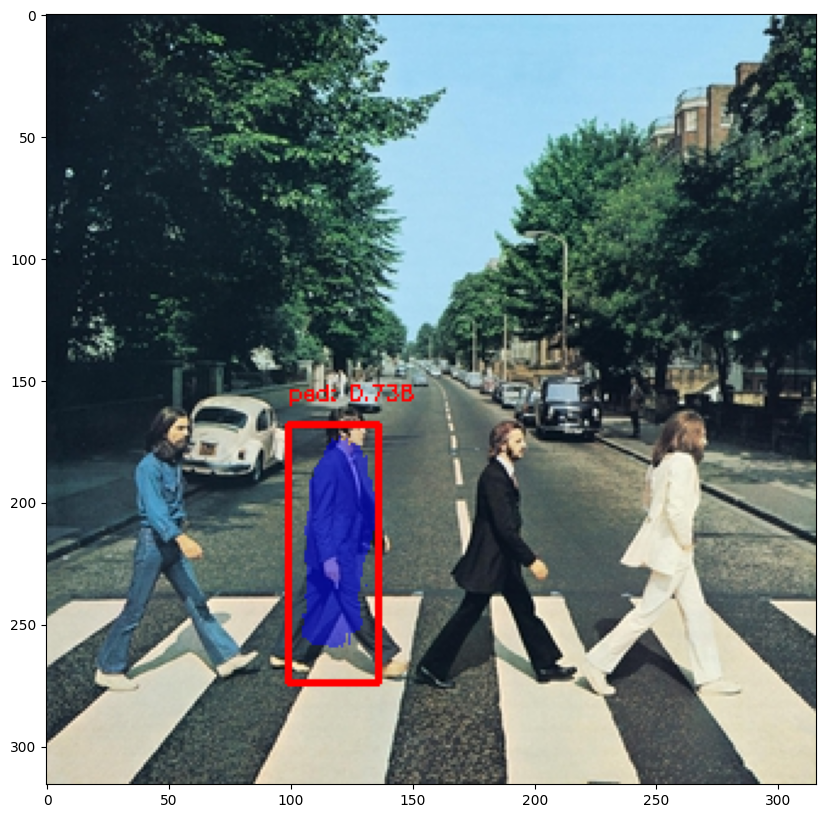

In [30]:
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Read an image from a specified path
image = read_image("/content/sample_data/Beatles_-_Abbey_Road.jpeg")

# Create an output image to visualize the results
output_image = image

# Obtain an evaluation transformation with 'train=False'
eval_transform = get_transform(train=False)

# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    # Make predictions using the model
    predictions = model([x, ])
    pred = predictions[0]

# Normalize and convert the image to 8-bit integers (uint8)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Filter predictions based on confidence scores (only keep scores > 0.65)
# mask refers to binary-mask ie true, false of predictions above confidence( not meaning the mask displayed in the image)
mask = pred["scores"] > 0.65
filtered_pred = {key: value[mask] for key, value in pred.items()}


#Obtaining labels, boxes and masks for filtered predictions
filtered_labels = [f"ped: {score:.3f}" for score in filtered_pred["scores"]]
filtered_boxes = filtered_pred["boxes"].long()
masks = (filtered_pred["masks"] > 0.7).squeeze(1)

#output image having the filtered prediction masks now
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Convert to NumPy array
output_image = output_image.permute(1, 2, 0).cpu().numpy().copy()

#Drawing the boxes, labels using cv2
for label, box in zip(filtered_labels, filtered_boxes):
    x_1, y_1, x_2, y_2 = [coord.item() for coord in box]
    output_image = cv2.rectangle(output_image, (x_1, y_1), (x_2, y_2), (255, 0, 0), 2)
    output_image = cv2.putText(output_image, label, (x_1, y_1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

#Plotting the final image
plt.figure(figsize=(10, 10))
plt.imshow(output_image)



In [32]:
print(pred["scores"])

tensor([0.7383, 0.5354, 0.5029, 0.4548, 0.3040, 0.2587, 0.0986, 0.0715, 0.0707],
       device='cuda:0')


**Comments on testing (method 1) result:**

In the above method for testing, predictions were inferred from the model. Each prediction dictionary consisted of labels, boxes, masks, confidence scores as keys.

Using confidence score threshold of 0.7, predctions in the list were filtered and the corresponding boxes, labels, masks for the the filtered predictions were outputed. In this case, of all prediction scores (as printed above) only one of them crossed the threshold.

**Tetsing of Backbone model on Beatles_Abbey_Road test image (Method 2)**

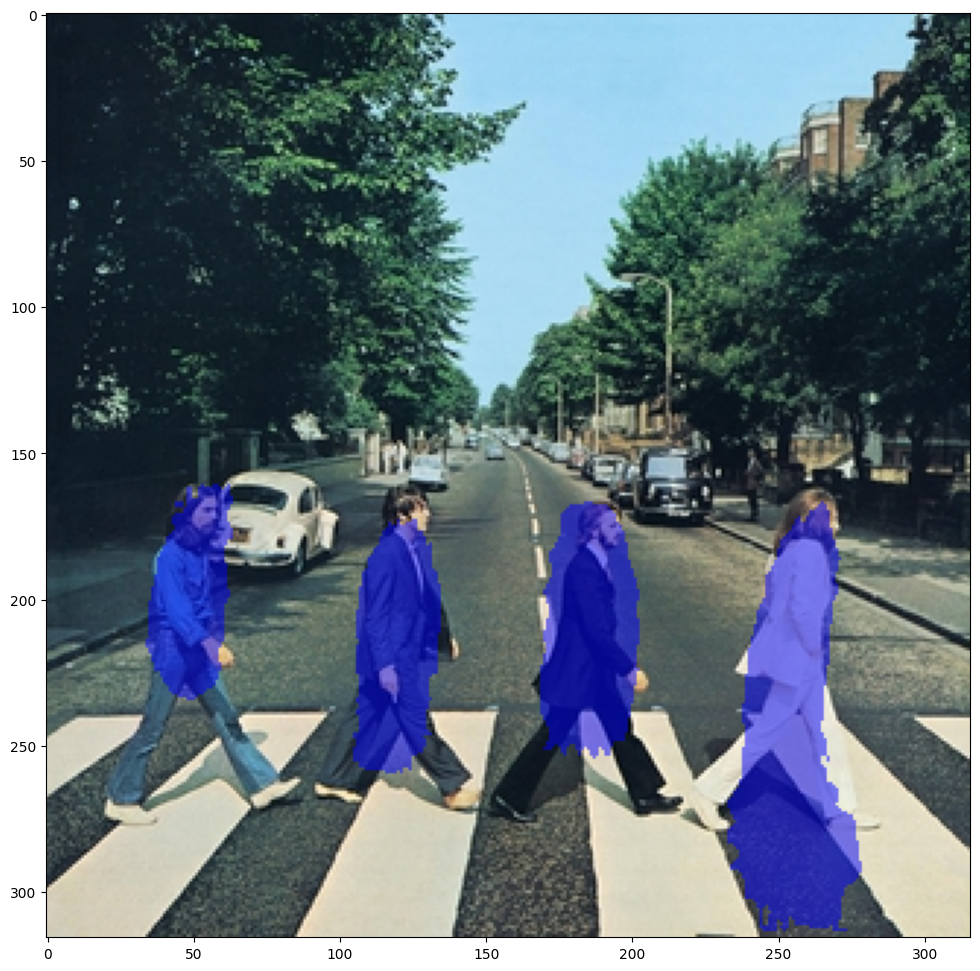

In [31]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Read an image from a specified path
image = read_image("/content/sample_data/Beatles_-_Abbey_Road.jpeg")

# Create an output image to visualize the results
output_image = image

# Obtain an evaluation transformation with 'train=False'
eval_transform = get_transform(train=False)

# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    # Make predictions using the model
    predictions = model([x, ])
    pred = predictions[0]

# Normalize and convert the image to 8-bit integers (uint8)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

#Filtering masks based on confidence
masks = (pred["masks"] > 0.7).squeeze(1)

#output image having the filtered prediction masks now
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

#Plotting the final output image
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))



**Comments on testing (method 2) result:**

In the above method for testing, predictions were inferred from the model.

From each prediction, the corresponding masks whose values exceeded the set threshold were used for the output image.

Prediction dictionaries with low scores like 0.1 etc might have some values in their masks as 0.8 etc ( above the threshod). These masks are included in this method but discared in the previous method.

**Q5.b)**

**Performance of two models on the training data after 10 epochs:**

*Option 1 model backbone resnet performance:*

Epoch: [9]  [59/60]  eta: 0:00:00  lr: 0.000005  loss: 0.1646 (0.1758)  loss_classifier: 0.0197 (0.0221)  loss_box_reg: 0.0283 (0.0343)  loss_mask: 0.1131 (0.1162)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0018 (0.0024)  time: 0.6305  data: 0.0085  max mem: 3779


*Option 2 model backbone Mobilenet performance:*

Epoch: [9]  [59/60]  eta: 0:00:00  lr: 0.000005  loss: 0.5627 (0.6184)  loss_classifier: 0.0730 (0.0846)  loss_box_reg: 0.1200 (0.1382)  loss_mask: 0.3146 (0.3338)  loss_objectness: 0.0403 (0.0433)  loss_rpn_box_reg: 0.0137 (0.0186)  time: 0.4404  data: 0.0092  max mem: 6244


Comparing the loss in paranthesis which represents the training loss of the entire dataset using the weights at the end of the 10th epoch, we can see option 1 model has loss of 0.1758 but option 2 has a loss of 0.6184, similarly loss_classifier for option 1 is 0.0221 but for option 2 is 0.0846. Similarly see for loss_mask, loss_rpn_box etc

**Thus option 1 model ( resnet backbone ) has lesser training loss than option 2 model ( mobilenet backbone ).**

Another way of comparing the performance is the training time.

*Option 1 model:*

Epoch: [9] Total time: 0:00:35 (0.5994 s / it)

*Option 2 model:*

Epoch: [9] Total time: 0:00:27 (0.4543 s / it)


In general, in the two model's training logs we can see that option 1 model takes more training time per epoch compared to option 2 model.

**Thus to summarize, Option 1 model ( Resnet ) has more accuracy than option 2 model ( Mobilenet ). But
Option 1 Model ( Resnet ) takes more training time compared to option 2 model ( MobileNet )**


**Q5C)**

*Testing method 1:*

In testing method 1, we saw that for option 1 model, four predictions crossed the set threshold and correspondigly four pedestrians were detected.

However, for option 2 model, only one prediction crossed the set threshold and correspondingly only one pedestrain was detected, thus missing the remaining pedestrians.

The bounding box co-ordinates and labels scores prediction in option 1 model is also better as the co-ordinates of the box are more or less bounding the pedesetrian correctly that too with a high confidence score.

*Testing method 2:*

The masks for option 1 model is almost correctly segmenting the four pedestrains

Whereas in option 2 model, some parts of the pedestrain like their legs etc are not masked or some parts of the road is also incorrectly masked.

 **To summarize, in terms of accuracy, option 1 Model (Resnet) is performing better than option 2 Model (Mobilenet) on the test image.**